#Projekt zaliczeniowy
Studia podyplomowe **"Data Science: poziom podstawowy" 2021/2022**, Uniwersytet Ekonomiczny we Wrocławiu

**Autor**: Agnieszka Michalak (505156)

**Temat**: Dobrostan psychiczny i uwarunkowania demograficzno-społeczne a poczucie szczęścia mieszkańców różnych państw - eksploracyjna analiza danych.

#Cel projektu

#Przygotowanie środowiska

Importuje biblioteki, z których będę korzystała podczas analizy danych.

In [1]:
import pandas as pd    
import numpy as np
from scipy import stats
import scipy.stats 
from scipy.stats import shapiro, boxcox
!pip install pingouin --upgrade
import pingouin as pg
from pingouin import kruskal
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=0f9a250b85485c777f7e396a5c00ab0900cd787c2f8a54cc49f538d1a16c6503
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
#import warnings
#warnings.filterwarnings('ignore')

#Import i przygotowanie danych

Przystępuję do wczytania danych, wyboru potrzebnych zmiennych, łączenia ramek danych, uzupełniania braków w danych.

In [2]:
from google.colab import files
uploaded=files.upload()


Saving 2022.csv to 2022.csv
Saving Data2022.csv to Data2022.csv
Saving prevalence-by-mental-and-substance-use-disorder.csv to prevalence-by-mental-and-substance-use-disorder.csv
Saving suicide-rates-vs-prevalence-of-mental-and-substance-use-disorders.csv to suicide-rates-vs-prevalence-of-mental-and-substance-use-disorders.csv
Saving suicide-rates-by-age-detailed----self harm.csv to suicide-rates-by-age-detailed----self harm.csv
Saving prevalence-of-depression-by-age.csv to prevalence-of-depression-by-age.csv
Saving prevalence-of-depression-males-vs-females.csv to prevalence-of-depression-males-vs-females.csv
Saving -male-vs-female-suicide.csv to -male-vs-female-suicide.csv
Saving suicide-death-rates-by-sexY.csv to suicide-death-rates-by-sexY.csv
Saving gdp_per_capita.csv to gdp_per_capita.csv
Saving annual-deaths-from-mental-and-substance-use-disorders.csv to annual-deaths-from-mental-and-substance-use-disorders.csv
Saving death-rates-from-mental-health-and-substance-use-disorders.csv 

In [ ]:
data=pd.read_csv('Data2022.csv', delimiter=',')
df_happiness=data.copy().sort_values(['Country name', 'year'])
df_happiness

In [ ]:
df_happiness.info()

In [ ]:
gdppercapita=pd.read_csv('gdp_per_capita.csv', delimiter=',')
df_gdpwide=gdppercapita.copy()
df_gdpwide.head(10)

In [ ]:
df_gdpwide.columns    # przygotowanie do zmiany formatu ramki danych z szerokiego na długi

In [ ]:
df_gdp=df_gdpwide.melt(id_vars=['Country Name', 'Code'], value_vars=['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001','2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010','2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019','2020'], var_name=['year'], value_name='gdp per capita')
df_gdp=df_gdp.sort_values(['Country Name', 'year'])
df_gdp

In [ ]:
df_gdp.info()

In [9]:
df_gdp['year']=df_gdp['year'].apply(pd.to_numeric)  # zmieniam typ danych na INT, aby możliwe było połączenie ramek danych poprzez wskazaną kolumnę

In [ ]:
df_happiness=pd.merge(df_happiness, df_gdp, how='left', left_on=['Country name', 'year'], right_on=['Country Name', 'year'])
df_happiness

W kolejnych krokach usunę niepotrzebne kolumny, zmienię nazwy kolumn (m.in. ujednolicę format ich zapisu) oraz sprawdzę, czy typy danych są właściwe do działań, jakie będą na nich wykonywane, a także w jakich kolumnach występują braki danych.

In [ ]:
df_happiness.info()

In [12]:
df_happiness.drop(['Country Name', 'Log GDP per capita'], axis=1, inplace=True)

In [13]:
df_happiness.columns=map(str.lower, df_happiness.columns) 

In [14]:
df_happiness.rename({'country name': 'country','code':'alpha-3'}, axis=1, inplace=True) 
df_happiness=df_happiness.sort_values(['country', 'year'])

In [ ]:
df_happiness.info()

In [ ]:
df_happiness['year'].min(), df_happiness['year'].max(), len(df_happiness['country'].unique())

Zbiór danych "*df_happiness"* zawiera.......... 1750 wierszy i 13 kolumn opisujących raportowany poziom satysfakcji życiowej mieszkańców 146 krajów w latach 2005-2020. 

Kolumny zawierające braki (oprócz tej, która zawiera dane o GDP per capita) przechowują informacje na temat tego jaka YYYYYYYYYY część wskaźnika satysfakcji jest wyjaśniana przez poszczgólną zmienną. Obserwowane braki danych nie są istotne dla dalszej analizy, ponieważ...........

In [ ]:
mentsubs=pd.read_csv('prevalence-by-mental-and-substance-use-disorder.csv', delimiter=',')
df_ment_subs=mentsubs.copy().sort_values(['Entity', 'Year'])
df_ment_subs

Wszystkie kolumny tabeli df_ment_subs zawierają dane dla obydwu płci, wystandaryzowane wg wieku.

In [ ]:
df_ment_subs.rename({'Entity':'country',
                     'Code':'alpha-3',
                     'Year':'year', 
                     'Prevalence - Schizophrenia - Sex: Both - Age: Age-standardized (Percent)':'schizophrenia',
                     'Prevalence - Bipolar disorder - Sex: Both - Age: Age-standardized (Percent)':'bipolar disorder',
                     'Prevalence - Eating disorders - Sex: Both - Age: Age-standardized (Percent)':'eating disorders',
                     'Prevalence - Anxiety disorders - Sex: Both - Age: Age-standardized (Percent)':'anxiety disorders',
                     'Prevalence - Drug use disorders - Sex: Both - Age: Age-standardized (Percent)':'drug use disorders',
                     'Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent)':'depressive disorders',
                     'Prevalence - Alcohol use disorders - Sex: Both - Age: Age-standardized (Percent)':'alcohol use disorders'}, 
                    axis=1, inplace=True)
df_ment_subs.head()

In [ ]:
df_ment_subs.info()   # późniejsze łączenie kilku ramek danych może rozwiązać kwestię brakujących wartości w kolumnie 'alpha-3'

In [ ]:
df_ment_subs['year'].min(), df_ment_subs['year'].max(), len(df_ment_subs['country'].unique())

In [ ]:
suic=pd.read_csv('suicide-death-rates-by-sexY.csv', delimiter=',')
df_suicide=suic.copy()   
df_suicide

In [ ]:
df_suicide.info()

In [ ]:
df_suicide['Year'].min(), df_suicide['Year'].max(), len(df_suicide['Entity'].unique())

In [ ]:
depr = pd.read_csv('prevalence-of-depression-males-vs-females.csv', delimiter=',')
df_depression=depr.copy()
df_depression

In [ ]:
df_depression.info()    # zastanawia mnie znacząca liczba wierszy tej ramki oraz spora róźnica w liczbie danych jakie zawierają poszczególne kolumny: szukam przyczyn

In [ ]:
df_depression['Year'].min(), df_depression['Year'].max(), len(df_depression['Entity'].unique())   # liczba przekracza wszystkie możliwe listy państw świata, sprawdzam co się w niej kryje

In [ ]:
list(df_depression['Entity'].unique())

Liczba rekordów w badanej DataFrame jest bliska 58 tysięcy, ponieważ zawiera dane pochodzące z lat 10000 p.n.e - 2021 n.e. oraz 321 krajów (np. nieistniejących, jak USSR). Nadmiarowe dane w szybki sposób zostaną wyłączone z dalszej analizy poprzez łączenie tej ramki danych z danymi o samobójstwach. 

In [ ]:
df_depr_suic=pd.merge(df_suicide, df_depression, how='inner', on=['Entity', 'Year'])
df_depr_suic.head()

In [ ]:
df_depr_suic.info()     # podobnie jak poprzednio, brakującymi wartościami zajmę się po połączeniu ramek danych

In [ ]:
df_depr_suic[df_depr_suic['Code_x'].isnull()].equals(df_depr_suic[df_depr_suic['Code_y'].isnull()])      # porównywane kolumny zawierają braki danych w tych samych wierszach, więc usunę dowolną z nich (oraz niepotrzebną zmienną 'Continent') 

In [33]:
df_depr_suic.drop(['Code_y', 'Continent'], axis=1, inplace=True)  

In [ ]:
df_depr_suic.rename({'Entity':'country', 
                   'Year':'year',
                   'Code_x':'alpha-3',                    
                   'Male suicide rate (age-standardized)':'male suicide rate',
                   'Female suicide rate (age-standardized)':'female suicide rate',
                   'Deaths - Self-harm - Sex: Both - Age: Age-standardized (Rate)':'deaths by self-harm rate (both sexes)',
                   'Prevalence - Depressive disorders - Sex: Male - Age: Age-standardized (Percent)':'male depressive disorder (percent)',
                   'Prevalence - Depressive disorders - Sex: Female - Age: Age-standardized (Percent)':'female depressive disorder (percent)',
                   'Population (historical estimates)':'population'}, axis=1, inplace=True)
df_depr_suic.head()

In [35]:
df_depr_suic=df_depr_suic.astype({'population': 'Int64'})

In [ ]:
df_depr_suic['year'].min(), df_depr_suic['year'].max(), len(df_depr_suic['country'].unique())

In [ ]:
mentals=pd.read_csv('suicide-rates-vs-prevalence-of-mental-and-substance-use-disorders.csv', delimiter=',')                                
df_suic_mental=mentals.copy()
df_suic_mental

In [ ]:
df_psychopathology=pd.merge(df_ment_subs, df_depr_suic, how='inner', on=['country', 'year', 'alpha-3'])
df_psychopathology

In [ ]:
df_psychopathology.info()

In [41]:
df_psychopathology['year'].min(), df_psychopathology['year'].max(), len(df_psychopathology['country'].unique())

(1990, 2019, 228)

W kolejnym kroku przyjrzę się rekordom, które zawierają w sobie braki danych: najpierw dla kolumn opisujących wskaźnik samobójstw dla kobiet i mężczyzn, potem te, które występują w danych dotyczących liczebności populacji badanych krajów. Wartościom NaN w kolumnmie 'alpha-3' przyjrzę się na końcu.

In [ ]:
f_suic_null=df_psychopathology[df_psychopathology['female suicide rate'].isnull()]
f_suic_null

In [ ]:
m_suic_null=df_psychopathology[df_psychopathology['male suicide rate'].isnull()]
m_suic_null['male suicide rate'].equals(f_suic_null['female suicide rate'])

In [ ]:
suic_bef_2018=f_suic_null.loc[f_suic_null['year']<2018]                   
suic_bef_2018

In [ ]:
suic_aft_2018=f_suic_null.loc[f_suic_null['year']>=2018]
suic_aft_2018

Analiza pierwszej z trzech powyższych ramek danych prowadzi do kilku wniosków, które potwierdziłam w kolejnych linijkach kodu, a mianowicie, że brakujące wartości w kolumnach wskaźnika samobójstw kobiet i mężczyzn:
*   pojawiają się w tych samych rekordach,
*   pojawiają się na przestrzeni wszystkich raportowanych lat m.in. w rejonach świata, tj. 'Africa Region (WHO)' (całościowy brak danych wyklucza możliwość zostawienia tych wierszy w mojej ramce danych),
*   występują także w szeregu innych krajów jedynie dla lat 2018 i 2019 (uzupełnię je danymi skopiowanymi z roku poprzedzającego wypełniany).

In [ ]:
index_to_drop=df_psychopathology[(df_psychopathology['male suicide rate'].isnull())&(df_psychopathology['year']<2018)].index
df_psychopathology.drop(index_to_drop, inplace=True)

countries_to_drop=set(list(suic_bef_2018['country'])).intersection(list(suic_aft_2018['country']))       #   jest Wales i England
index_to_drop2=df_psychopathology[((df_psychopathology['female suicide rate'].isnull())|(df_psychopathology['year']>=2018))&(df_psychopathology['country'].isin(countries_to_drop))].index      #czemu??????????
df_psychopathology.drop(index_to_drop2, inplace=True)

df_psychopathology.info()

In [ ]:
to_fill=['female suicide rate', 'male suicide rate']
df_psychopathology[to_fill]=df_psychopathology[to_fill].ffill()
df_psychopathology.info()

In [ ]:
df_psychopathology['year'].min(), df_psychopathology['year'].max(), len(df_psychopathology['country'].unique())

Usunęłam z ramki danych wszystkie rekordy nie zawierające danych o wskaźniku samobójstw dla kobiet i mężczyzn, ponieważ byłyby one zbędne w dalszych etapach analizy. W wyniku wykonania tej operacji w DataFrame zniknęły także puste wartości z kolumn *alpha-3* i *population* (co oznacza, że znajdowały się one wyłącznie w usuniętych wierszach). Ramka danych dotycząca psychopatologii zawierają teraz 5432 rekordy, dla 194 krajów, opisujące lata 1990-2017.

In [ ]:
df_all=pd.merge(df_happiness[['country', 'year', 'life ladder', 'gdp per capita','healthy life expectancy at birth']], df_psychopathology, how='inner', on=['country', 'year'],)
df_all

In [ ]:
df_all.info() 

Zbiorcza ramka danych *df_all* zawiera 1768 wierszy z danymi zabranymi w 19 kolumnach. Typy danych odpowiadają zawartości kolumn, nie wymagają zmian. W 136 rekordach brakuje danych o produkcie krajowym brutto na mieszkańca, uzupełnię je danymi ze strony internetowej Banku Światowego.

In [ ]:
df_all[df_all['gdp per capita'].isnull()]

In [ ]:
nowe=pd.read_csv('5ccc4db6-7673-414d-8d2a-bb75d91f1dad_Data.csv', delimiter=',')
df_nowe=nowe.copy()
df_nowe.head()

In [ ]:
df_nowe.drop(['Series Name', 'Series Code'], axis=1, inplace=True)
df_nowe.drop(index=[14, 15, 16, 17, 18], axis=0, inplace=True)

for col in df_nowe.columns[2:]:
    df_nowe.rename(columns={col:col.split(' ')[0]}, inplace=True)
df_nowe

In [ ]:
df_nowe_melted=df_nowe.melt(id_vars=['Country Name', 'Country Code'], value_vars=df_nowe.columns[2:], var_name=['year'], value_name='gdp per capita')
df_nowe_melted=df_nowe_melted.sort_values(['Country Name', 'year'])
df_nowe_melted

In [ ]:
df_nowe_melted['gdp per capita']=df_nowe_melted['gdp per capita'].replace('..', np.nan)
df_nowe_melted.info()

In [ ]:
df_nowe_melted[df_nowe_melted['gdp per capita'].isnull()]

In [ ]:
df_nowe_melted[['year', 'gdp per capita']]=df_nowe_melted[['year', 'gdp per capita']].apply(pd.to_numeric)  # zmieniam typ danych na INT, aby możliwe było połączenie ramek danych poprzez wskazaną kolumnę

df_nowe_melted.rename({'Country Code':'alpha-3'}, axis=1, inplace=True)
df_nowe_melted.info()

In [ ]:
df_all=pd.merge(df_all, df_nowe_melted[['year', 'alpha-3', 'gdp per capita']], how='left', on=['year', 'alpha-3'])
df_all

In [ ]:
df_all['gdp per capita']=df_all['gdp per capita_x'].fillna(df_all['gdp per capita_y'])
df_all.drop(['gdp per capita_x', 'gdp per capita_y'], axis=1, inplace=True)
df_all.info()

In [ ]:
df_all['gdp per capita']=df_all['gdp per capita'].ffill()
df_all.info()

In [ ]:
#---------------------------------------

In [ ]:
depr_age = pd.read_csv('prevalence-of-depression-by-age.csv', delimiter=',')
df_depr_age=depr_age.copy()
df_depr_age

In [ ]:
df_depr_age.info()

In [ ]:
df_depr_age.drop(['Prevalence - Depressive disorders - Sex: Both - Age: 20 to 24 (Percent)', 
                  'Prevalence - Depressive disorders - Sex: Both - Age: 30 to 34 (Percent)',
                  'Prevalence - Depressive disorders - Sex: Both - Age: 15 to 19 (Percent)',
                  'Prevalence - Depressive disorders - Sex: Both - Age: 25 to 29 (Percent)',
                  'Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent)'], axis=1, inplace=True)
df_depr_age.head()

In [ ]:
death_age=pd.read_csv('suicide-rates-by-age-detailed----self harm.csv', delimiter=',')
df_death_age=death_age.copy()
df_death_age.head()

In [ ]:
df_death_age.info()         # dane prawie kompletne, brak kodów nazw krajów do niektórych państw

In [ ]:
df_psychopathology_age=pd.merge(df_depr_age, df_death_age, how='inner', on=['Entity', 'Year', 'Code'])
df_psychopathology_age.rename({'Entity': 'country','Code':'code', 'Year': 'year'}, axis=1, inplace=True) 
df_psychopathology_age.head()

In [ ]:
df_psychopathology_age=pd.merge(df_psychopathology_age, df_psychopathology[['country', 'year', 'population']], how='inner', on=['country', 'year'])
df_psychopathology_age.head()

In [ ]:
df_psychopathology_age.info()

In [84]:
df_psychopathology_age.rename({'Prevalence - Depressive disorders - Sex: Both - Age: 10 to 14 (Percent)':'depressive disorder (10-14)',    
                               'Prevalence - Depressive disorders - Sex: Both - Age: All Ages (Percent)':'depressive disorder (all ages)',
                               'Prevalence - Depressive disorders - Sex: Both - Age: 70+ years (Percent)':'depressive disorder (70+)',
                               'Prevalence - Depressive disorders - Sex: Both - Age: 50-69 years (Percent)':'depressive disorder (50-69)',
                               'Prevalence - Depressive disorders - Sex: Both - Age: 15-49 years (Percent)':'depressive disorder (15-49)'}, axis=1, inplace=True)

In [ ]:
for col in df_psychopathology_age.columns[8:13]:                                                                              # zamieniam rate na procent
    df_psychopathology_age[col]=(df_psychopathology_age[col]*100000/df_psychopathology_age['population']).round(decimals=3)     
df_psychopathology_age.head()

In [71]:
df_psychopathology_age.rename({'Deaths - Self-harm - Sex: Both - Age: 70+ years (Rate)':'death - self harm (70+)',    
                               'Deaths - Self-harm - Sex: Both - Age: 50-69 years (Rate)':'death - self harm (50-69)',
                               'Deaths - Self-harm - Sex: Both - Age: All Ages (Rate)':'death - self harm (all ages)',
                               'Deaths - Self-harm - Sex: Both - Age: 5-14 years (Rate)':'death - self harm  (5-14)',
                               'Deaths - Self-harm - Sex: Both - Age: 15-49 years (Rate)':'death - self harm (15-49)'}, axis=1, inplace=True)

In [72]:
df_psychopathology_age.head()

country code  year  depressive disorder (10-14)  \
0  Afghanistan  AFG  1990                         1.80   
1  Afghanistan  AFG  1991                         1.78   
2  Afghanistan  AFG  1992                         1.77   
3  Afghanistan  AFG  1993                         1.76   
4  Afghanistan  AFG  1994                         1.76   

   depressive disorder (all ages)  depressive disorder (70+)  \
0                            4.00                       5.58   
1                            3.96                       5.58   
2                            3.90                       5.58   
3                            3.86                       5.58   
4                            3.82                       5.58   

   depressive disorder (50-69)  depressive disorder (15-49)  \
0                         6.96                         6.43   
1                         6.97                         6.37   
2                         6.98                         6.32   
3                         6.99                         6.32   
4                         7.00                         6.35   

   death - self harm (70+)  death - self harm (50-69)  \
0                      0.1                      0.117   
1                    0.098                      0.115   
2                    0.087                      0.102   
3                    0.075                      0.089   
4                    0.069                      0.082   

   death - self harm (all ages)  death - self harm  (5-14)  \
0                         0.057                      0.004   
1                         0.055                      0.004   
2                         0.049                      0.003   
3                         0.042                      0.003   
4                         0.038                      0.002   

   death - self harm (15-49)  population  
0                      0.095    10694804  
1                      0.092    10745168  
2                      0.082    12057436  
3                      0.072    14003764  
4                      0.067    15455560

In [ ]:
df_psychopathology_age['year'].min(), df_psychopathology_age['year'].max(), len(df_psychopathology_age['country'].unique())

#Eksploracyjna analiza danych


In [ ]:
df_all.loc[:, 'life ladder':].describe().round(decimals=3)        

In [88]:
columns_desstat=['life ladder', 'gdp per capita', 'healthy life expectancy at birth', 'schizophrenia', 'bipolar disorder', 'eating disorders', 'anxiety disorders', 
                 'drug use disorders', 'depressive disorders', 'alcohol use disorders', 'female suicide rate', 'male suicide rate', 'deaths by self-harm rate (both sexes)',
                 'male depressive disorder (percent)','female depressive disorder (percent)', 'population']

In [ ]:
fig, axes = plt.subplots(2,8, figsize=(20,6))

for i, col in enumerate(list(df_all[columns_desstat].columns.values)):
  a = df_all.boxplot(col, ax=axes.flatten()[i], fontsize='small')

plt.tight_layout() 
plt.show()

In [ ]:
q1=df_all[columns_desstat].quantile(0.25)
q3=df_all[columns_desstat].quantile(0.75)
iqr=q3-q1

((df_all[columns_desstat]<(q1-1.5*iqr))|(df_all[columns_desstat]>(q3+1.5*iqr))).sum()/len(df_all[columns_desstat])

In [ ]:
df_eda=pd.DataFrame()
df_eda['skew']=df_all[columns_desstat].skew().round(decimals=3)
df_eda['kurtosis']=df_all[columns_desstat].kurtosis().round(decimals=3)
df_eda['variance']=df_all[columns_desstat].var().round(decimals=3)
df_eda

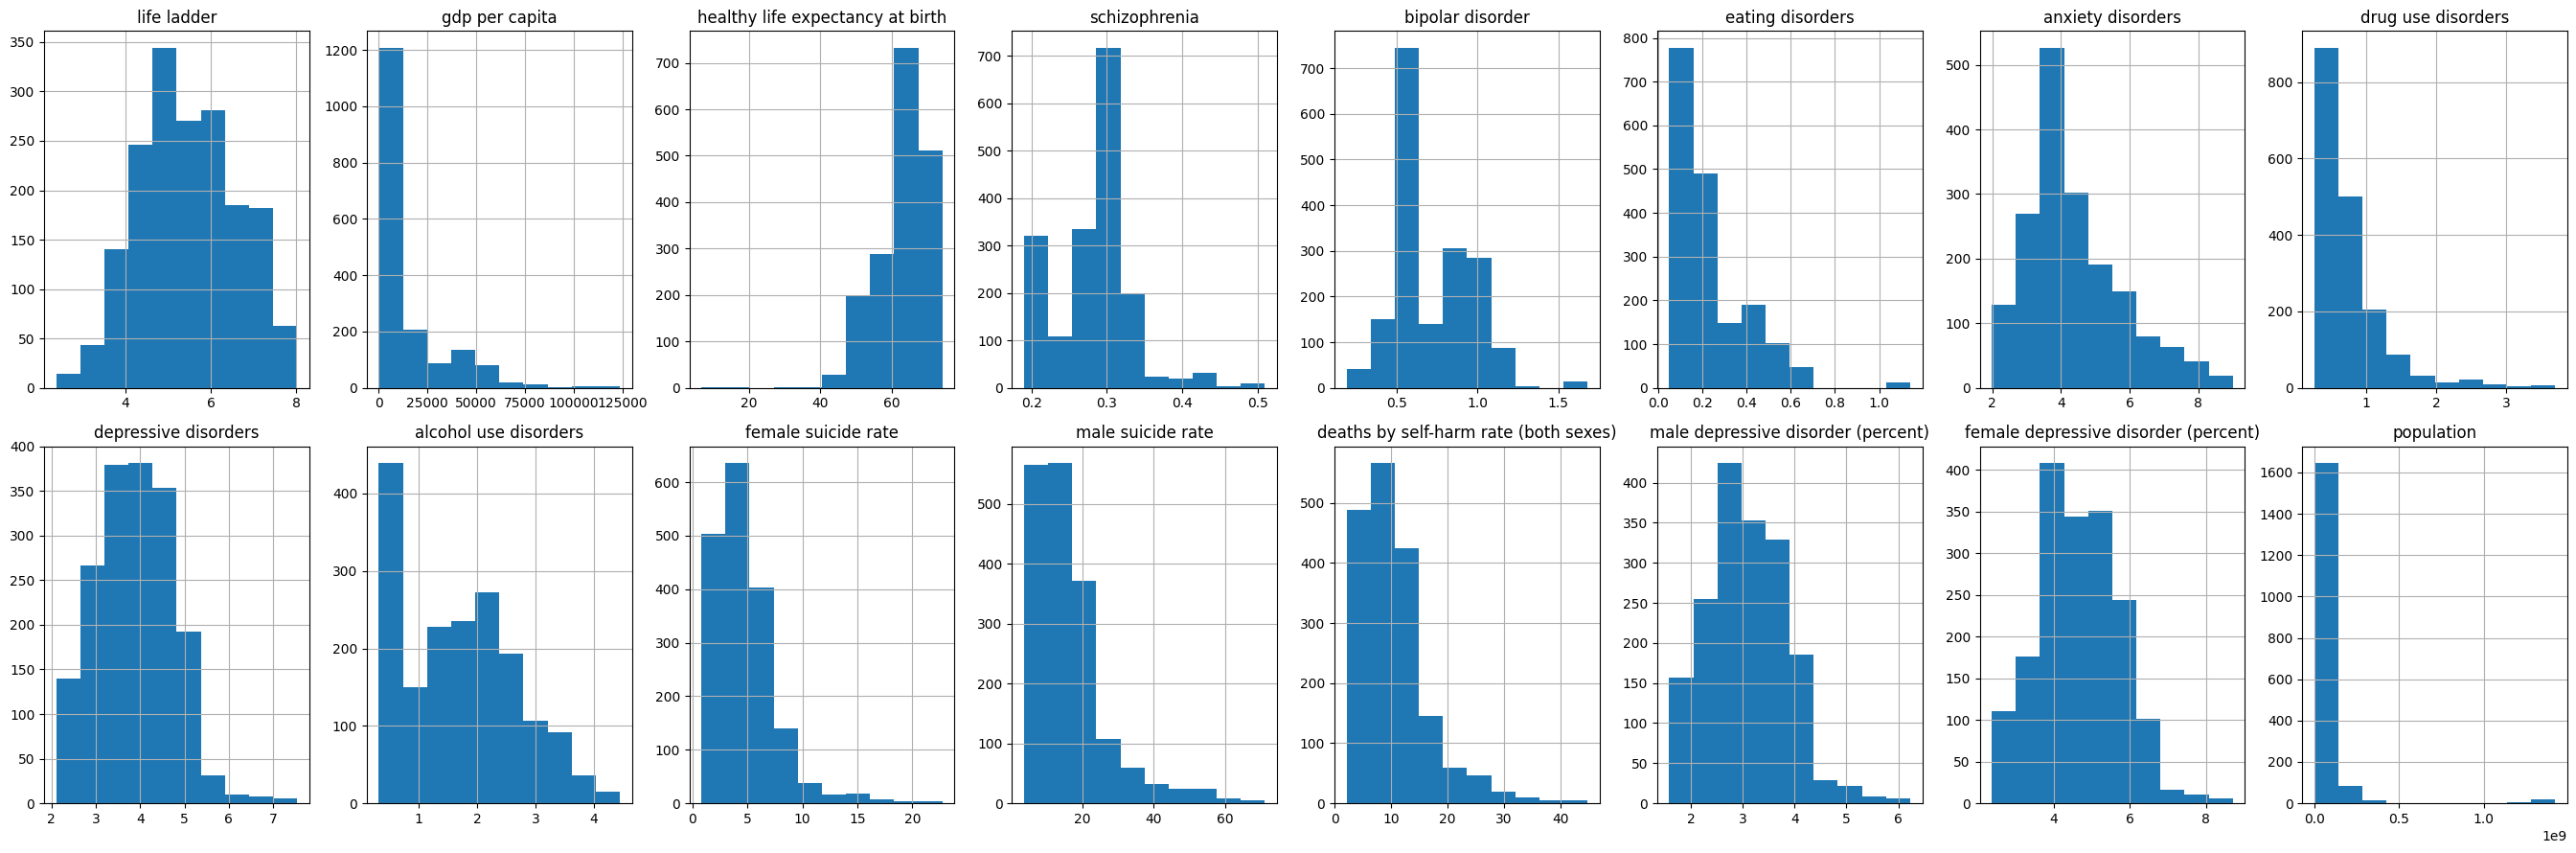

In [91]:
fig, axes = plt.subplots(2,8)

for i, el in enumerate(list(df_all[columns_desstat].columns.values)):
  a = df_all.hist(el, ax=axes.flatten()[i])
  
fig.set_size_inches(27, 9)
plt.tight_layout() 
plt.show()

In [ ]:
sns.set(font_scale=1.0)                                                                                                                                                              #rozkład dwumodalny
sns.distplot(df_all['life ladder'], color='forestgreen', axlabel='poziom satysfakcji życiowej').set(title='Histogram poziomu satysfakcji życiowej dla wszystkich krajów')
plt.ylabel('częstość występowania')

In [ ]:
df_all2=df_all.copy()                                                                                                                          

df_all2['gdp per capita']=df_all2['gdp per capita'].ffill()
df_all2.info()

In [99]:
columns_desstat2=['life ladder', 'gdp per capita', 'healthy life expectancy at birth', 'schizophrenia', 'bipolar disorder', 'eating disorders', 'anxiety disorders', 
                 'drug use disorders', 'depressive disorders', 'alcohol use disorders', 'deaths by self-harm rate (both sexes)']    #bez populacji

for col in df_all2[columns_desstat2]:           
  print(col+':', shapiro(df_all2[col]))

life ladder: ShapiroResult(statistic=0.9857193231582642, pvalue=2.9784742380800644e-12)
gdp per capita: ShapiroResult(statistic=0.7135269641876221, pvalue=0.0)
healthy life expectancy at birth: ShapiroResult(statistic=0.9170987606048584, pvalue=4.444335372662363e-30)
schizophrenia: ShapiroResult(statistic=0.8999650478363037, pvalue=1.7353546860016987e-32)
bipolar disorder: ShapiroResult(statistic=0.9387117624282837, pvalue=2.0684453706351892e-26)
eating disorders: ShapiroResult(statistic=0.8040139675140381, pvalue=6.567885902290418e-42)
anxiety disorders: ShapiroResult(statistic=0.940746009349823, pvalue=5.126955550748667e-26)
drug use disorders: ShapiroResult(statistic=0.7727869153022766, pvalue=3.783505853677006e-44)
depressive disorders: ShapiroResult(statistic=0.9862955808639526, pvalue=6.161131934495634e-12)
alcohol use disorders: ShapiroResult(statistic=0.9459940195083618, pvalue=5.980740571285983e-25)
deaths by self-harm rate (both sexes): ShapiroResult(statistic=0.8721498250961

<ipython-input-95-5bc7c70cfa52>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_all2['gdp per capita'], hist=True, kde=True, kde_kws={'fill':True, 'linewidth':2}, color="forestgreen")


<Axes: xlabel='gdp per capita', ylabel='Density'>

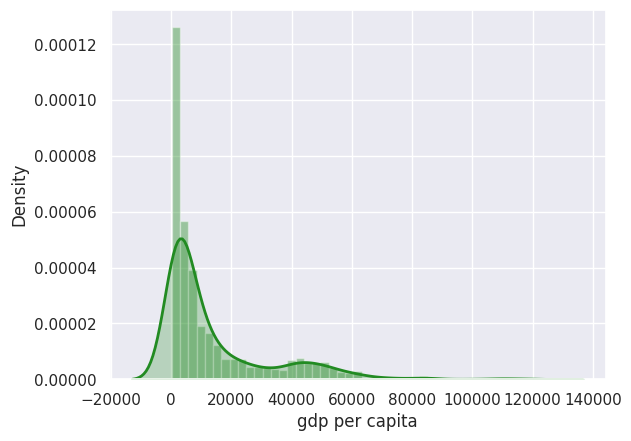

In [95]:
sns.distplot(df_all2['gdp per capita'], hist=True, kde=True, kde_kws={'fill':True, 'linewidth':2}, color="forestgreen")

[[[Dla zmiennej *gdp per capita* p-value jest mniejsza od 0,05, zatem rozkład zmiennej nie jest normalny. Wartość p zmiennej *life ladder* (oraz pozostałych) przekracza wartość 0,05, zatem brak podstaw do stwierdzenia, że dane nie pochodzą z rozkładu normalnego.]]]

Próba normalizacji zmiennej GDP: przekształcenie Boxa-Coxa

In [100]:
df_all_bc=df_all2.copy()

<ipython-input-103-eaa550ef0529>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(trans_data, bins=10, hist=True, kde=True, kde_kws={'fill':True, 'linewidth':2}, color="forestgreen")


<Axes: ylabel='Density'>

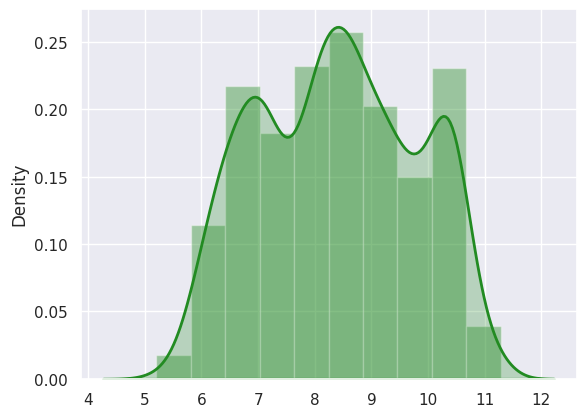

In [103]:
trans_data, trans_lambda=boxcox(df_all_bc['gdp per capita'])
sns.distplot(trans_data, bins=10, hist=True, kde=True, kde_kws={'fill':True, 'linewidth':2}, color="forestgreen")

In [105]:
shapiro(df_all_bc['gdp per capita'])

ShapiroResult(statistic=0.7135269641876221, pvalue=0.0)

Próba normalizacji zmiennej GDP: nałożenie logarytmu.

In [106]:
df_all3=df_all2.copy()
df_all3['gdp per capita']=np.log(df_all['gdp per capita'])

<ipython-input-107-2f33ac138409>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_all3['gdp per capita'], bins=10, color='forestgreen', axlabel='GPD per capita').set(title='Histogram GDP per capita dla wszystkich krajów')


Text(0, 0.5, 'częstość występowania')

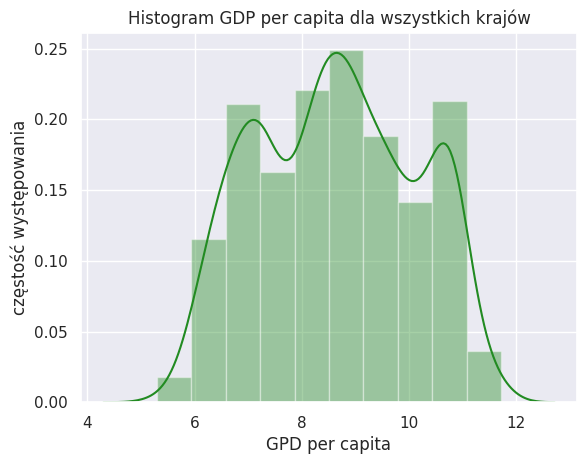

In [107]:
sns.set(font_scale=1.0)                                                                                                                                               
sns.distplot(df_all3['gdp per capita'], bins=10, color='forestgreen', axlabel='GPD per capita').set(title='Histogram GDP per capita dla wszystkich krajów')
plt.ylabel('częstość występowania')

In [108]:
shapiro(df_all3['gdp per capita'])              # histogram sugeruje rozkład trzymodalny ale wynik Shapiro-Wilka nie daje podstaw do odrzucenia hipotezy o normalności testu........?

ShapiroResult(statistic=0.9716300964355469, pvalue=3.382064419224125e-18)

[[[[Po nałożeniu logarytmu  wartość p zmiennej *gdp per capita* przekracza wartość 0.05, zatem brak podstaw do stwierdzenia, że dane nie pochodzą z rozkładu normalnego.]]]

In [ ]:
#---------------------------------

In [109]:
pip install fitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fitter: filename=fitter-1.5.2-py3-none-any.whl size=25608 sha256=027038caa365437a267a771ffebb007089ef147ac4c6154223db1ea0f8752b5d
  Stored in directory: /root/.cache/pip/wheels/eb/50/1d/6d8762c6a9a50d3668e53f98164ba13ca314827fb5ac7ebeaa
Successfully built fitter


In [112]:
df_all10=df_all.copy()                                                                                                                          

df_all10['gdp per capita']=df_all10['gdp per capita'].ffill()

Fitting 110 distributions:  91%|█████████ | 100/110 [02:26<00:18,  1.90s/it]/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
Fitting 110 distributions:  96%|█████████▋| 106/110 [02:54<00:16,  4.14s/it]/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
Fitting 110 dis

sumsquare_error          aic           bic  kl_div  \
geninvgauss       1.066909e-09  2645.811872 -49714.722297     inf   
genhyperbolic     1.143751e-09  2647.153976 -49584.283870     inf   
johnsonsb         1.560710e-09  2630.028195 -49042.218662     inf   
reciprocal        1.768133e-09  2506.530939 -48821.602001     inf   
loguniform        1.768133e-09  2506.530939 -48821.602001     inf   

               ks_statistic     ks_pvalue  
geninvgauss        0.046344  9.732740e-04  
genhyperbolic      0.045420  1.314364e-03  
johnsonsb          0.046810  8.343973e-04  
reciprocal         0.095366  1.906791e-14  
loguniform         0.095366  1.906791e-14

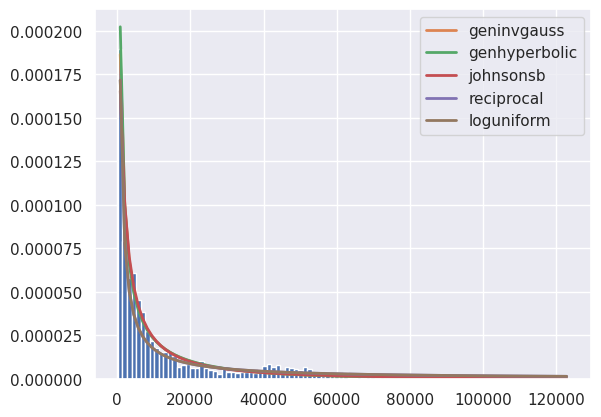

In [113]:
from fitter import Fitter
f = Fitter(df_all10['gdp per capita'])
f.fit()
f.summary()

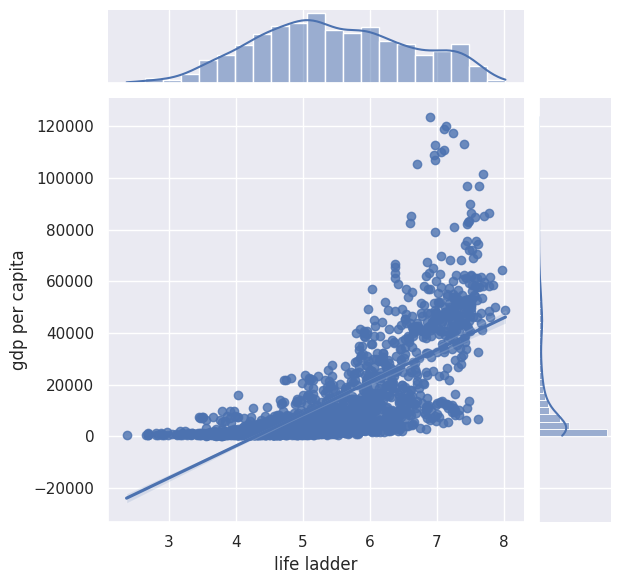

In [ ]:
sns.jointplot(data=df_all10, x='life ladder', y='gdp per capita', kind='reg')

In [ ]:
#----------------------------------

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the int

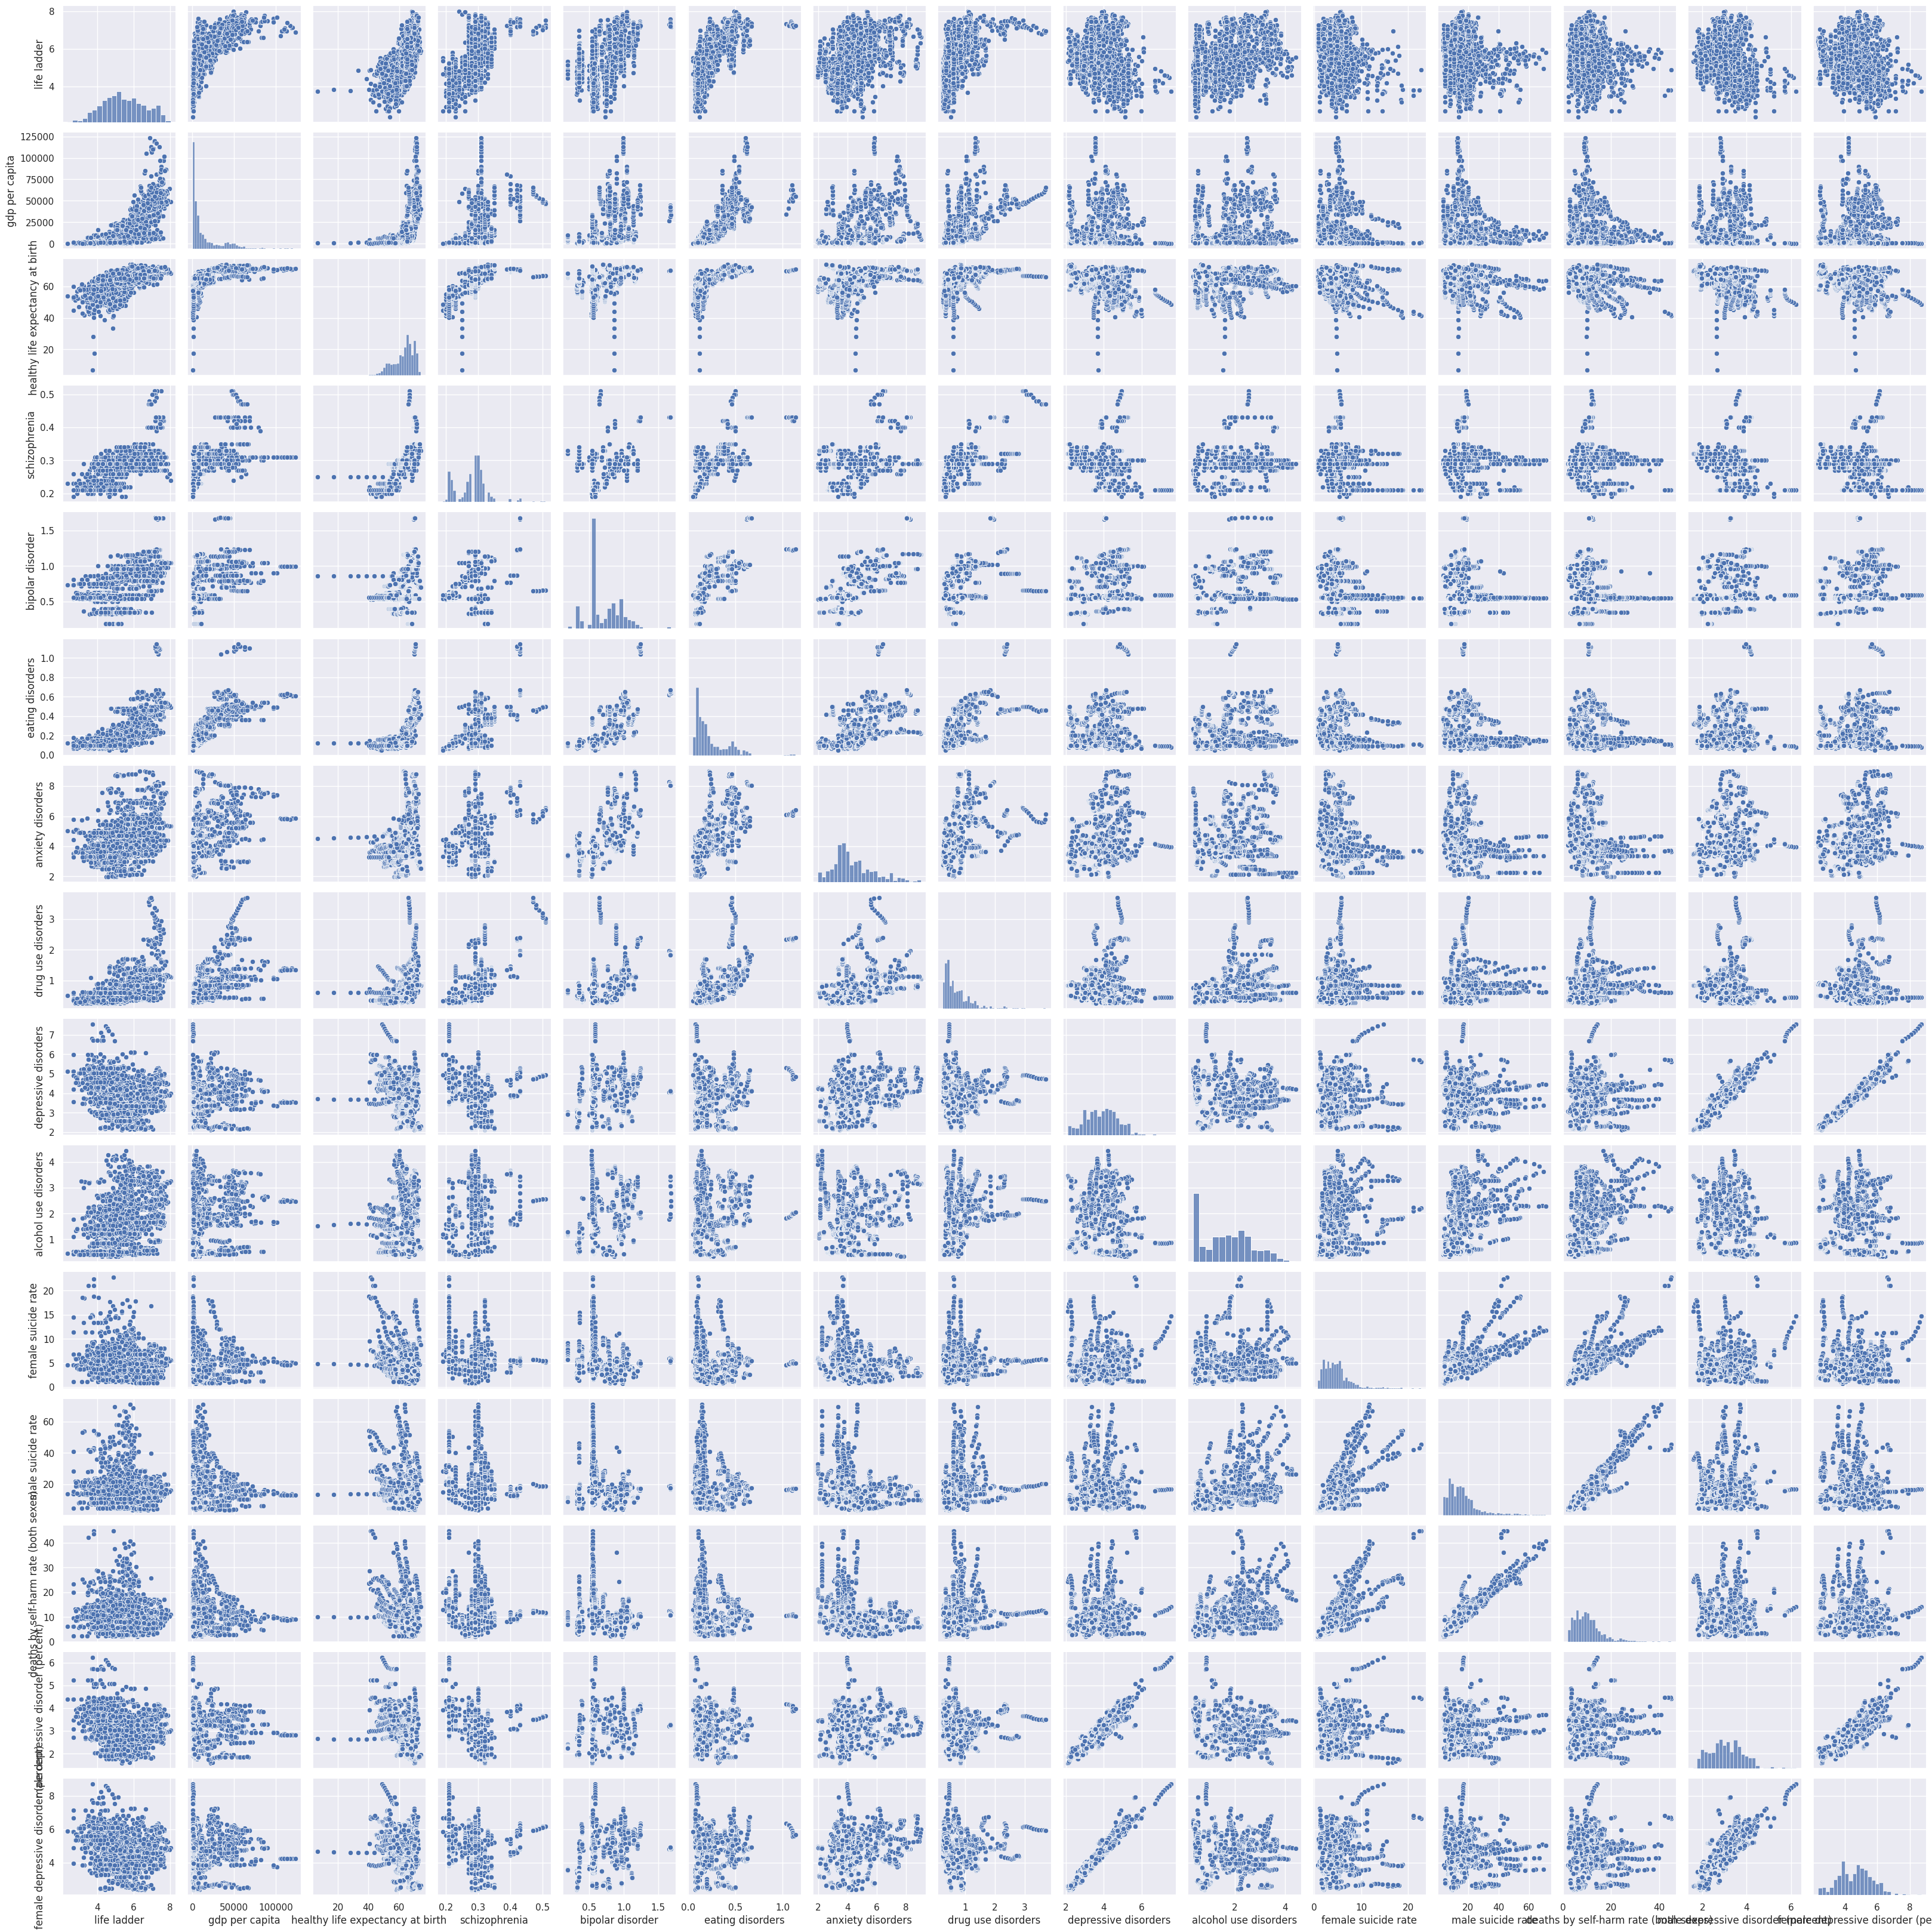

In [ ]:
#sns.pairplot(df_all[['life ladder', 'gdp per capita', 'healthy life expectancy at birth', 'schizophrenia', 'bipolar disorder', 'eating disorders', 'anxiety disorders', 'drug use disorders', 'depressive disorders', 'alcohol use disorders', 
                     'female suicide rate', 'male suicide rate', 'deaths by self-harm rate (both sexes)', 'male depressive disorder (percent)', 'female depressive disorder (percent)']], height=2.2)
#plt.show()

W następnym kroku przyjrzę się zależnościom między zmiennymi: obliczę współczynniki korelacji rang Spearmana oraz sprawdzę ich istotność statystyczną.

Text(0.5, 1.0, 'Macierz korelacji rang Spearmana')

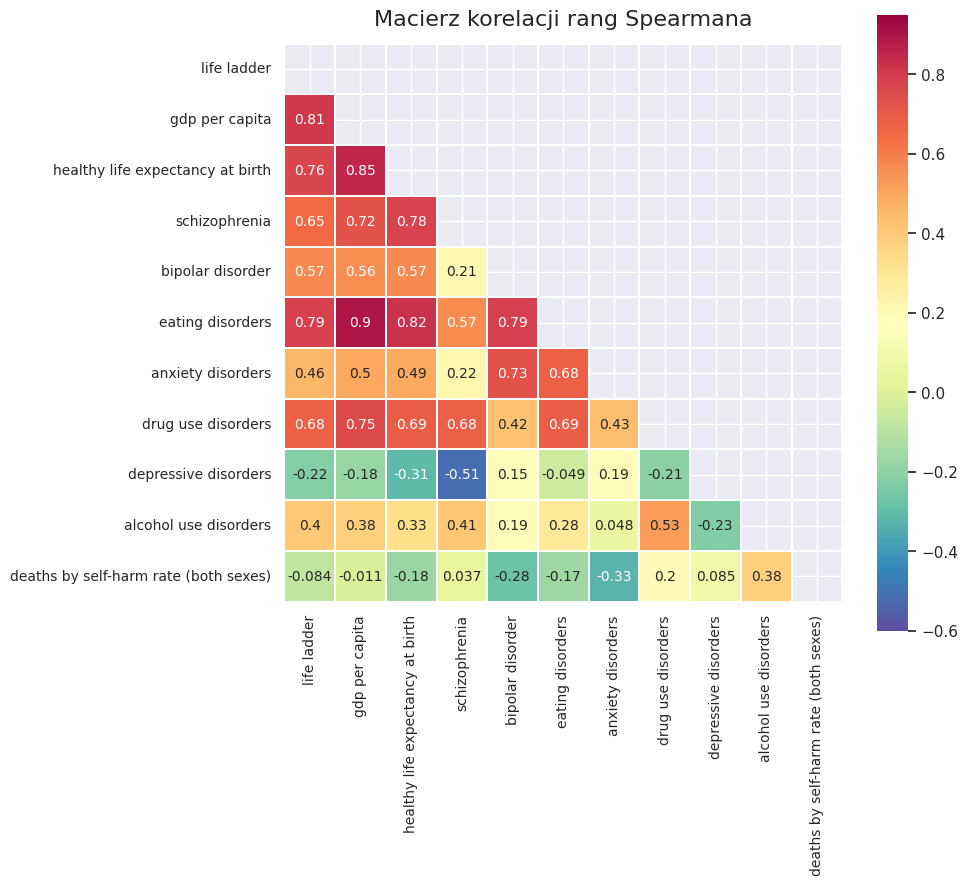

In [115]:
plt.figure(figsize=(9, 8))   
corr_psychop=df_all10[columns_desstat2].corr(method='spearman').round(decimals=3)
mask=np.zeros_like(corr_psychop)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr_psychop, cmap='Spectral_r', mask=mask, square=True, vmin=-.6, vmax=0.95, annot=True, annot_kws={"size":10}, linewidths=1.2, linecolor='white')
plt.tick_params(labelsize=10)
plt.title('Macierz korelacji rang Spearmana', fontsize=16, pad=13)

In [116]:
df_all10[columns_desstat2].rcorr(method='spearman')

life ladder gdp per capita  \
life ladder                                     -            ***   
gdp per capita                              0.809              -   
healthy life expectancy at birth            0.763           0.85   
schizophrenia                               0.648          0.723   
bipolar disorder                            0.569           0.56   
eating disorders                            0.785          0.898   
anxiety disorders                           0.456          0.496   
drug use disorders                          0.675          0.752   
depressive disorders                       -0.219         -0.181   
alcohol use disorders                       0.403          0.379   
deaths by self-harm rate (both sexes)      -0.084         -0.011   

                                      healthy life expectancy at birth  \
life ladder                                                        ***   
gdp per capita                                                     ***   
healthy life expectancy at birth                                     -   
schizophrenia                                                    0.778   
bipolar disorder                                                 0.571   
eating disorders                                                 0.825   
anxiety disorders                                                0.491   
drug use disorders                                               0.685   
depressive disorders                                            -0.311   
alcohol use disorders                                            0.329   
deaths by self-harm rate (both sexes)                           -0.176   

                                      schizophrenia bipolar disorder  \
life ladder                                     ***              ***   
gdp per capita                                  ***              ***   
healthy life expectancy at birth                ***              ***   
schizophrenia                                     -              ***   
bipolar disorder                              0.212                -   
eating disorders                              0.568            0.788   
anxiety disorders                              0.22            0.731   
drug use disorders                            0.679            0.421   
depressive disorders                         -0.514            0.149   
alcohol use disorders                         0.409            0.188   
deaths by self-harm rate (both sexes)         0.037           -0.277   

                                      eating disorders anxiety disorders  \
life ladder                                        ***               ***   
gdp per capita                                     ***               ***   
healthy life expectancy at birth                   ***               ***   
schizophrenia                                      ***               ***   
bipolar disorder                                   ***               ***   
eating disorders                                     -               ***   
anxiety disorders                                 0.68                 -   
drug use disorders                               0.688              0.43   
depressive disorders                            -0.049             0.189   
alcohol use disorders                            0.284             0.048   
deaths by self-harm rate (both sexes)           -0.169            -0.326   

                                      drug use disorders depressive disorders  \
life ladder                                          ***                  ***   
gdp per capita                                       ***                  ***   
healthy life expectancy at birth                     ***                  ***   
schizophrenia                                        ***                  ***   
bipolar disorder                                     ***                  ***   
eating disorders                                     ***            

Na początku przyjrzę się jak zmieniał się poziom poczucia szczęścia mieszkańców całego świata w latach 2007 - 2019. Następnie zidentyfikuję najmniej i najbardziej szczęśliwe narodowości w latach 2007 i 2019 oraz stworzę ranking krajów utworzony na podstawie średniego poziomu raportowanego poczucia szczęścia (uwzględniający wszystkie badane lata).

In [117]:
happiness_map=px.choropleth(df_all.sort_values('year'),                
              locations='alpha-3',
              color='life ladder', 
              hover_name='country',
              hover_data=['year', 'life ladder'],
              animation_frame='year',
              color_continuous_scale="YlGn",
              locationmode='ISO-3',
              scope='world',
              labels={'life ladder':'poziom<br>satysfakcji<br>życiowej'},
              range_color=(2.0, 8.2),
              width=1600,
              height=950)
happiness_map.update_layout(title_text='Poziom raportowanej satysfakcji życiowej na świecie w latach 2005-2019', font=dict(size=15), title_x=0.5)
happiness_map

In [118]:
to_agg={'life ladder': ['describe']}                                                # podstawowe statystyki opisowe dla zmiennej 'life ladder' dla poszczególnych krajów
df_all_describe=df_all.groupby(['country']).agg(to_agg).round(2)
df_all_describe.columns=df_all_describe.columns.droplevel([0, 1])
df_all_describe=df_all_describe.reset_index()
df_all_describe['range']=df_all_describe['max']-df_all_describe['min']  
df_all_describe

country  count  mean   std   min   25%   50%   75%   max  range
0    Afghanistan   12.0  3.59  0.74  2.38  3.02  3.75  4.04  4.76   2.38
1        Albania   12.0  4.99  0.45  4.51  4.63  4.90  5.32  5.87   1.36
2        Algeria    8.0  5.39  0.47  4.74  5.20  5.33  5.50  6.35   1.61
3         Angola    4.0  4.42  0.82  3.79  3.90  4.15  4.67  5.59   1.80
4      Argentina   14.0  6.34  0.30  5.79  6.08  6.43  6.55  6.78   0.99
..           ...    ...   ...   ...   ...   ...   ...   ...   ...    ...
152    Venezuela   14.0  6.12  1.02  4.04  5.20  6.39  6.94  7.48   3.44
153      Vietnam   14.0  5.31  0.21  5.02  5.11  5.30  5.46  5.77   0.75
154        Yemen   12.0  3.91  0.57  2.98  3.62  4.01  4.25  4.81   1.83
155       Zambia   13.0  4.53  0.59  3.31  4.04  4.73  5.00  5.26   1.95
156     Zimbabwe   14.0  3.93  0.67  2.69  3.62  3.78  4.56  4.96   2.27

[157 rows x 10 columns]

In [119]:
agg_des={'country':'count', 'life ladder':['mean', 'min', 'median', 'max', 'std', 'var']}           # podstawowe statystyki opisowe dla zmiennej 'life ladder' dla poszczególnych lat (wraz z liczebą krajów, których dane zostały zagregowane)
df_all_year=df_all.groupby(['year']).agg(agg_des).round(3)
df_all_year.columns=df_all_year.columns.droplevel(0)
df_all_year=df_all_year.reset_index()
df_all_year['range']=df_all_year['max']-df_all_year['min']
df_all_year

year  count   mean    min  median    max    std    var  range
0   2005     27  6.446  4.719   6.620  8.019  0.919  0.845  3.300
1   2006     86  5.187  3.202   5.080  7.672  1.107  1.225  4.470
2   2007    100  5.434  3.280   5.238  7.834  1.050  1.103  4.554
3   2008    105  5.444  2.808   5.191  7.971  1.182  1.397  5.163
4   2009    108  5.493  3.408   5.375  7.683  1.035  1.070  4.275
5   2010    119  5.506  3.229   5.464  7.771  1.142  1.304  4.542
6   2011    139  5.443  2.936   5.267  7.788  1.100  1.209  4.852
7   2012    134  5.463  3.164   5.337  7.776  1.135  1.289  4.612
8   2013    130  5.415  2.688   5.269  7.594  1.188  1.412  4.906
9   2014    137  5.416  2.839   5.381  7.508  1.165  1.356  4.669
10  2015    136  5.424  2.702   5.379  7.603  1.126  1.269  4.901
11  2016    134  5.411  2.693   5.424  7.660  1.158  1.342  4.967
12  2017    140  5.471  2.662   5.587  7.788  1.157  1.339  5.126
13  2018    136  5.494  2.694   5.449  7.858  1.098  1.206  5.164
14  2019    137  5.569  2.375   5.626  7.780  1.131  1.279  5.405

Jak wynika z tabeli, z upływającymi latami obserwujemy wzrost zmienności poziomu satysfakcji życiowej (wyrażony poprzez rozstęp).

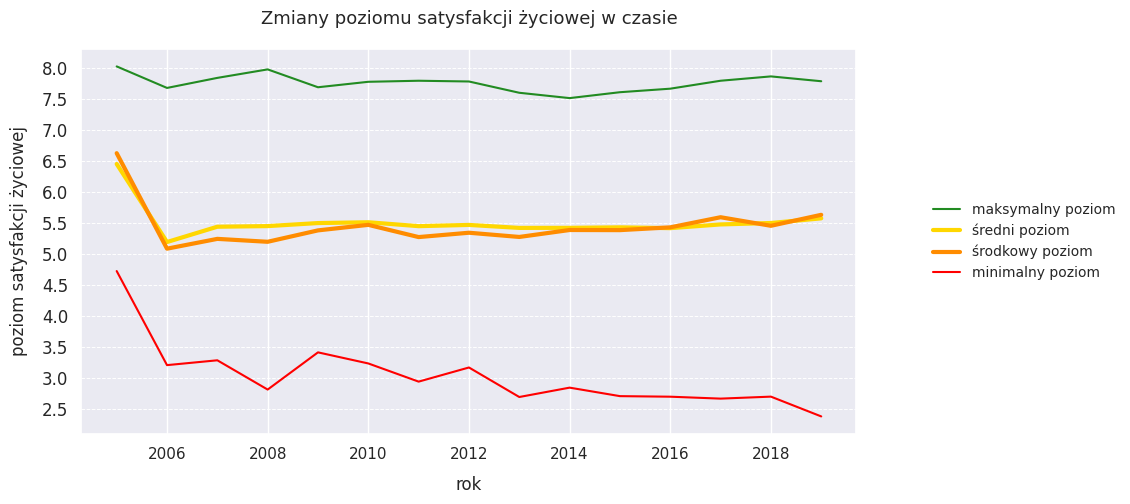

In [120]:
plt.rcParams['figure.figsize']=(10, 5)                                                              
plt.plot(df_all_year['year'], df_all_year['max'], color='forestgreen')
plt.plot(df_all_year['year'], df_all_year['mean'], linewidth=3, color='gold')
plt.plot(df_all_year['year'], df_all_year['median'], linewidth=3, color='darkorange')
plt.plot(df_all_year['year'], df_all_year['min'], color='red')
plt.title('Zmiany poziomu satysfakcji życiowej w czasie', fontsize=13, pad=18)
plt.yticks(np.arange(2.5, 8.5, 0.5), fontsize=12)
plt.grid(axis='y', linestyle = '--', linewidth = 0.7)
plt.xlabel('rok', fontsize=12, labelpad=10)
plt.ylabel('poziom satysfakcji życiowej', fontsize=12, labelpad=10)
plt.legend(['maksymalny poziom', 'średni poziom', 'środkowy poziom', 'minimalny poziom'], prop = {'size' : 10}, bbox_to_anchor=(1.35, 0.5), loc='center right', frameon=False)
plt.show()

Średni poziom satysfakcji życiowej od 2006 roku zaczyna utrzymuje się na mniej więcej stałym poziomie, z niewielką tendencją wzrostową od 2016 roku. Obserowowany spadek średniej w latach 2005-2006 zapewne wynika z niekompletnych danych, co można zaoważyć dzięki analizie kartogramu:

*   w 2005 roku nie zostały zebrane dane dla dwóch regionów świata (Afryka, Południowa Azja), w których przeciętny poziom satysfkacji utrzymuje się na wyraźnie niższym poziomie niż najszczęśliwszych rejonów świata (Europa, Ameryka Północna, Australia), stąd najwyższa (w obserowanym okresie) średnia tej zmiennej;
*   rak danych z części krajów europejskich i Autralii, spowodował spadek średniej, a pojawienie się  informacji z Afryki i Południowej Azji jeszcze pogłębiło ów spadek;
* wzrost średniej satysfakcji życiowej w 2007 wynika z pojawienia się kompletnych danych z Australii, Ameryki Północnej, większości danych z Europy.



In [121]:
mean_top=df_all_describe.sort_values('mean', ascending=False).head(20)         
mean_bottom=df_all_describe.sort_values('mean').head(20)       
countries=list(mean_top['country'])
countries_bottom=list(mean_bottom['country'])

a=df_all[df_all['country'].isin(list(mean_top['country']))]
b=df_all[df_all['country'].isin(list(mean_bottom['country']))]

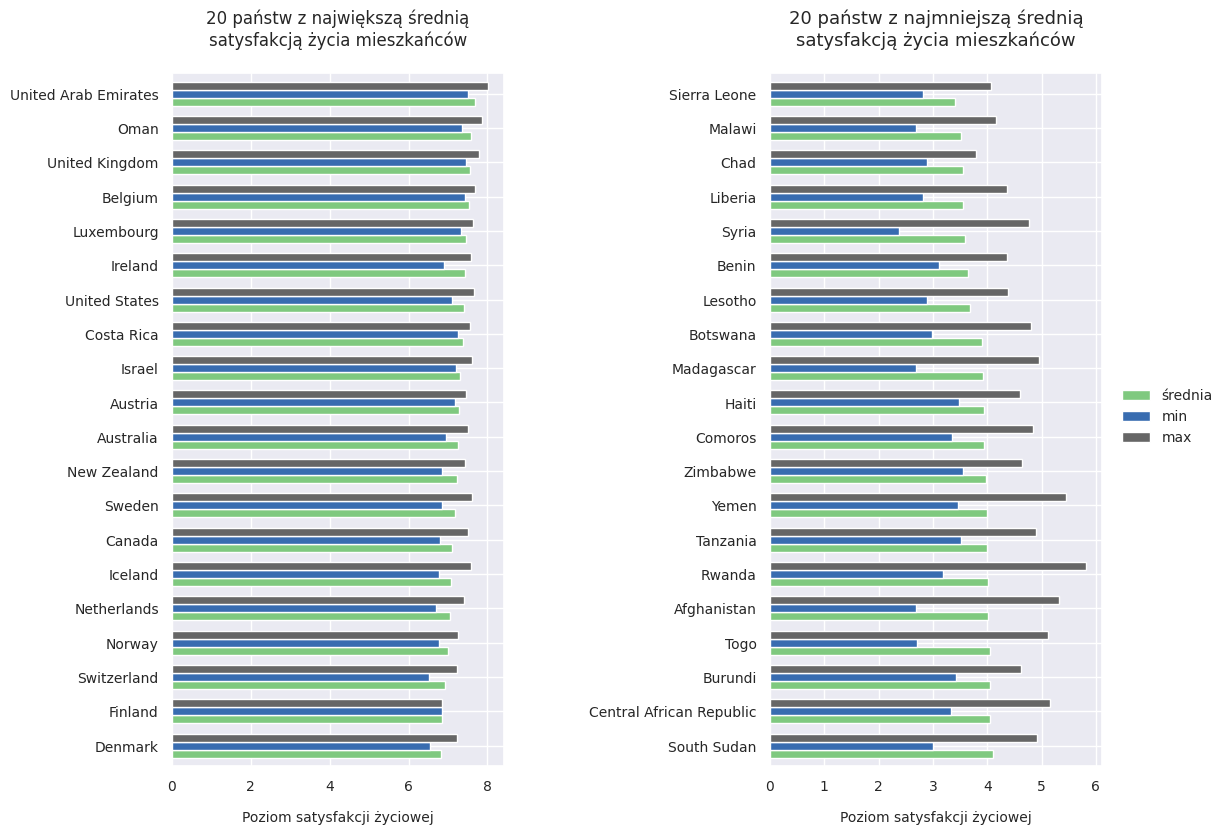

In [122]:
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(12, 9))

mean_top[['mean', 'min', 'max']].sort_values('mean', ascending=True).plot(kind='barh', width = 0.7, ax=ax1, colormap='Accent', fontsize=10)
ax1.set_xlabel('Poziom satysfakcji życiowej', fontsize=10, labelpad=12)
ax1.set_title('20 państw z największą średnią\nsatysfakcją życia mieszkańców', fontsize=12, pad=20)
ax1.set_yticklabels(countries)
ax1.get_legend().remove()

mean_bottom[['mean', 'min', 'max']].sort_values('mean', ascending=False).plot(kind='barh', width = 0.7, ax=ax2, colormap='Accent', fontsize=10)
ax2.set_xlabel('Poziom satysfakcji życiowej', fontsize=10, labelpad=12)
ax2.set_title('20 państw z najmniejszą średnią\nsatysfakcją życia mieszkańców', fontsize=13, pad=20)
ax2.set_yticklabels(countries_bottom)
ax2.get_legend().remove()

fig.subplots_adjust(wspace=0.8)
fig.legend(['średnia', 'min', 'max'], prop = {'size' : 10}, loc='center right', frameon=False)
fig.show()

In [123]:
df_2007_happiness=df_all.query("year==2007")
df_2007_the_happiest=df_2007_happiness.sort_values('life ladder', ascending=False).head(20)
df_2007_the_unhappiest=df_2007_happiness.sort_values('life ladder').head(20)

df_2019_happiness=df_all.query("year==2019")
df_2019_the_happiest=df_2019_happiness.sort_values('life ladder', ascending=False).head(20)    
df_2019_the_unhappiest=df_2019_happiness.sort_values('life ladder').head(20)

b=df_all[df_all['country'].isin(list(df_2007_the_happiest['country']))]
c=df_all[df_all['country'].isin(list(df_2007_the_unhappiest['country']))]

d=df_all[df_all['country'].isin(list(df_2019_the_happiest['country']))]
e=df_all[df_all['country'].isin(list(df_2019_the_unhappiest['country']))]

fig2007=pd.concat([b, c], ignore_index=True)
fig2019=pd.concat([d, e], ignore_index=True)

In [124]:
figura=px.line(x=fig2007['year'], y=fig2007['life ladder'], color=fig2007['country'], hover_name=fig2007['country'])
figura.update_layout(title='Zmiany poziomu satysfakcji życiowej w czasie<br>w krajach o najwyższym i najniższym poziomie tej cechy w 2007 roku',
                    title_x=0.45,
                    title_font_size=22,
                    #title_pad=12,
                    xaxis_title='rok',
                    yaxis_title='poziom satysfakcji życiowej',
                    legend_title='',
                    legend_font_size=12,
                    legend_y=0.5,
                    font=dict(size=14),
                    hoverlabel=dict(bgcolor="white", font_size=14),
                    width=1600,
                    height=800)
figura.update_traces(hovertemplate='rok: %{x}, poziom satysfakcji życiowej: %{y}')
figura.add_hline(y=5.45, line_width=2, line_dash="dash", line_color="darkorange")   
figura.show()

In [125]:
figura=px.line(x=fig2019['year'], y=fig2019['life ladder'], color=fig2019['country'], hover_name=fig2019['country'])
figura.update_layout(title='Zmiany poziomu satysfakcji życiowej w czasie<br>w krajach o najwyższym i najniższym poziomie tej cechy w 2019 roku',
                    title_x=0.45,
                    title_font_size=22,
                    #title_pad=12,
                    xaxis_title='rok',
                    yaxis_title='poziom satysfakcji życiowej',
                    legend_title='',
                    legend_font_size=12,
                    legend_y=0.5,
                    font=dict(size=14),
                    hoverlabel=dict(bgcolor="white", font_size=14),
                    width=1600,
                    height=800)
figura.update_traces(hovertemplate='rok: %{x}, poziom satysfakcji życiowej: %{y}')
figura.add_hline(y=5.45, line_width=2, line_dash="dash", line_color="darkorange") 
figura.show()

In [126]:
bar=go.Bar(x=df_2007_the_happiest['country'],
           y=df_2007_the_happiest['life ladder'],
           name='2007', 
           marker_color='lightseagreen')

bar1=go.Bar(x=df_2019_the_happiest['country'],
            y=df_2019_the_happiest['life ladder'],
            name='2019',
            marker_color='forestgreen')

data=[bar, bar1]       
plotly.offline.iplot({'data':data,
                      'layout':go.Layout(barmode='group', 
                                         title="Najbardziej szczęśliwe kraje świata w latach 2007 i 2019",
                                         title_x=0.5,
                                         title_font=dict(size=20),
                                         legend_font=dict(size=16),
                                         width=1500, height=550)})              

In [127]:
bar=go.Bar(x=df_2007_the_unhappiest['country'],
           y=df_2007_the_unhappiest['life ladder'],
           name='2007',
           marker_color='lightseagreen')

bar1=go.Bar(x=df_2019_the_unhappiest['country'],
            y=df_2019_the_unhappiest['life ladder'],
            name='2019',
            marker_color='forestgreen')

data=[bar, bar1]
plotly.offline.iplot({"data": data,
                      "layout": go.Layout(barmode='group', 
                                          title="Najmniej szczęśliwe kraje świata w latach 2007 i 2019 - TOP 20",
                                          title_x=0.5,
                                          title_font=dict(size=20),
                                          legend_font=dict(size=16),
                                          width=1500, height=550)})

PODSUMOWANIE POWYŻSZYCH:...................

In [128]:
df_all_range=df_all_describe[['country', 'range']].sort_values('range')  
df_all_range=df_all_range[df_all_range['range']> 0]

fig=go.Figure()
fig.update_layout(barmode='group', title_text='Kraje o najmniejszym i największym zakresie zmienności poziomu satysfakcji życiowej w całym badanym okresie')
fig.add_trace(go.Bar(x=df_all_range['country'].head(20), y=df_all_range['range'].head(20)))
fig.add_trace(go.Bar(x=df_all_range['country'][-20:], y=df_all_range['range'][-20:]))

In [129]:
df_change, df_change2=(pd.DataFrame(), pd.DataFrame())
for index, row in df_2007_happiness.iterrows():
  df_change['country']=df_2007_happiness['country']
  df_change['life ladder 2007']=df_2007_happiness['life ladder']

for index, row in df_2019_happiness.iterrows():
  df_change2['country']=df_2019_happiness['country']
  df_change2['life ladder 2019']=df_2019_happiness['life ladder']

df_diff=df_change.merge(df_change2, on='country', how='inner')
df_diff['life ladder change']=df_diff['life ladder 2019']-df_diff['life ladder 2007']
df_diff.sort_values('life ladder change', inplace=True)

fig = go.Figure()
fig.update_layout(barmode='group', title_text='Największe zmiany w poziomie satysfakcji życiowej w porównaniu lat 2007 i 2019')
fig.add_trace(go.Bar(x=df_diff['country'].head(20), y=df_diff['life ladder change'].head(20)))
fig.add_trace(go.Bar(x=df_diff['country'][-20:], y=df_diff['life ladder change'][-20:]))


In [ ]:
df_all4=df_all10.groupby('country').mean().reset_index()
df_all4.head()

In [171]:
figg=px.scatter(df_all4, x='gdp per capita', y='life ladder', size=list(df_all4['population']), size_max=70, hover_name=df_all4['country'], 
                title='Związek między wysokością PKB na mieszkańca a poziomem satysfakcji życiowej<br>dla wszystkich krajów świata (z uwzględnieniem wielkości populacji)', 
                color_continuous_scale=px.colors.sequential.Viridis, range_color=[0.05,1.4], height=800, width=1400)
figg.update_layout(legend=dict(x=0, y=1, font=dict(size=12), bgcolor="white", bordercolor="white"),
                   title=dict(font_size=20, x=0.45))
figg.update_xaxes(title='PKB na mieszkańca (USD)')
figg.update_yaxes(title='poziom satysfakcji życiowej')
figg.show()

### REGRESJA LINIOWA - **bez logarytmowania danych GDP**



In [132]:
df_all5=df_all10.copy()

index_gdp=df_all5[df_all5['gdp per capita'].isnull()].index
df_all5.drop(index_gdp, inplace=True)

In [133]:
lin_reg=pg.linear_regression(df_all5['gdp per capita'], df_all5['life ladder'])        # przewidywanie satysfakcji życiowej na postawie GDP per capita
lin_reg.round(2)

names  coef    se       T  pval    r2  adj_r2  CI[2.5%]  CI[97.5%]
0       Intercept  4.87  0.02  209.33   0.0  0.51    0.51      4.82       4.91
1  gdp per capita  0.00  0.00   43.26   0.0  0.51    0.51      0.00       0.00

*GDP per capita* jest istotnym statystycznie (T = 57.68, p-value < 0.05) predyktorem satysfakcji życiowej. Współczynnik determinacji (tak jak skorygowany współczynnik determinacji) wynosi 0.67, co znaczy, że stworzony model regresji wyjaśnia około 67% zmienności satysfakcji życiowej. 

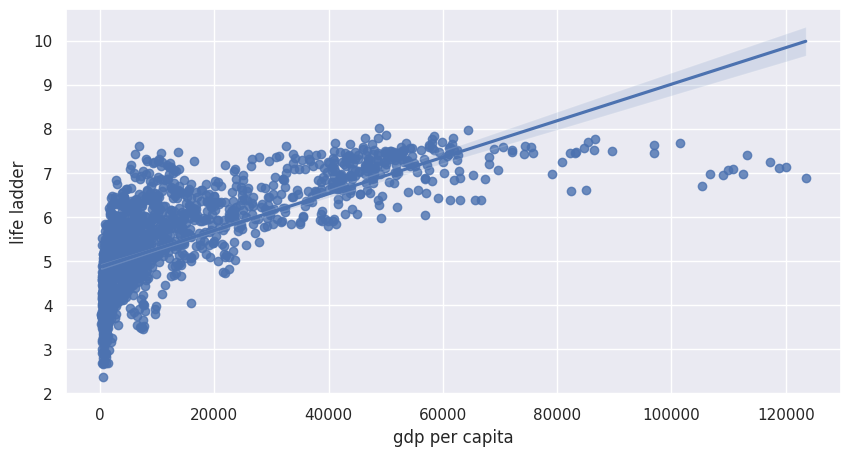

In [134]:
corr_l_g=pg.corr(df_all5['gdp per capita'], df_all5['life ladder'], method='spearman')
sns.regplot(x='gdp per capita', y='life ladder', data=df_all5)
plt.show()

In [135]:
corr_l_g

n         r         CI95%  p-val  power
spearman  1768  0.808894  [0.79, 0.82]    0.0    1.0

In [136]:
 pg.homoscedasticity(df_all5[['life ladder', 'gdp per capita']], method="bartlett", alpha=.05)

T  pval  equal_var
bartlett  32030.866957   0.0      False

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------

In [137]:
depression_map=px.choropleth(df_psychopathology_age.sort_values('year'),                
              locations='code',
              color='depressive disorder (15-49)', 
              hover_name='country',
              hover_data=['year', 'depressive disorder (15-49)'],
              animation_frame='year',
              color_continuous_scale="YlGnBu",
              locationmode='ISO-3',
              scope='world',
              labels={'depressive disorder (15-49)':'procent mieszkanców<br>chorych na depresję'},
              range_color=(2, 10.8),
              width=1600,
              height=950)
depression_map.update_layout(title_text='Częstoliwość występowania depresji na świecie w latach 1990-2019', font=dict(size=15), title_x=0.5)
depression_map

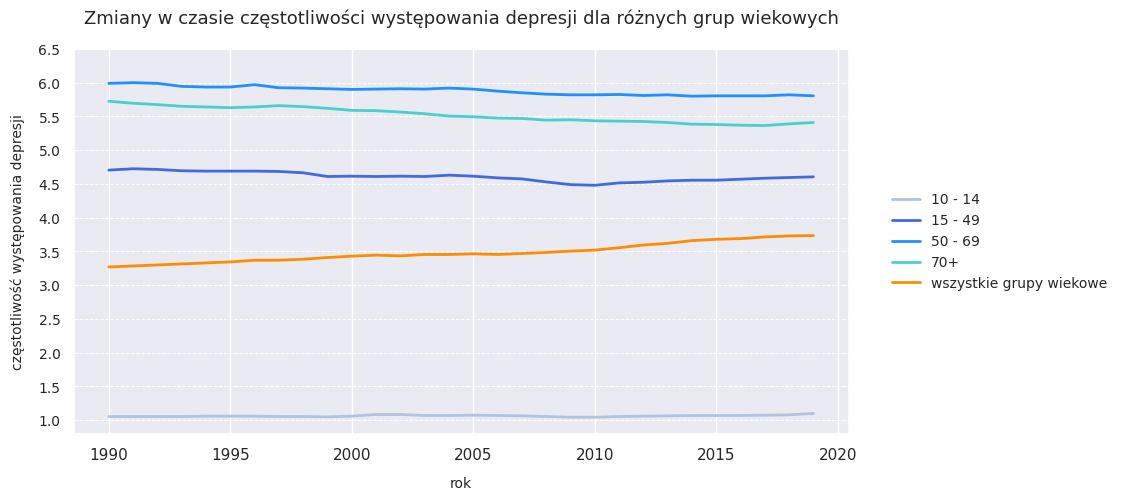

In [163]:
k=df_psychopathology_age[['year', 'depressive disorder (10-14)', 'depressive disorder (15-49)', 'depressive disorder (50-69)', 'depressive disorder (70+)', 'depressive disorder (all ages)']].groupby('year').median().reset_index()

plt.rcParams['figure.figsize']=(10, 5)       
plt.plot(k['year'], k['depressive disorder (10-14)'], linewidth=2, color='lightsteelblue')                                                       
plt.plot(k['year'], k['depressive disorder (15-49)'], linewidth=2, color='royalblue')
plt.plot(k['year'], k['depressive disorder (50-69)'], linewidth=2, color='dodgerblue')
plt.plot(k['year'], k['depressive disorder (70+)'], linewidth=2, color='mediumturquoise')
plt.plot(k['year'], k['depressive disorder (all ages)'], linewidth=2, color='darkorange')
plt.title('Zmiany w czasie częstotliwości występowania depresji dla różnych grup wiekowych', fontsize=13, pad=18)
plt.yticks(np.arange(1.0, 7.0, 0.5), fontsize=10)
plt.grid(axis='y', linestyle = '--', linewidth = 0.7)
plt.xlabel('rok', fontsize=10, labelpad=10)
plt.ylabel('częstotliwość występowania depresji', fontsize=10, labelpad=10)
plt.legend(['10 - 14', '15 - 49', '50 - 69', '70+', 'wszystkie grupy wiekowe'], prop = {'size' : 10}, bbox_to_anchor=(1.35, 0.5), loc='center right', frameon=False)
plt.show()

Sprawdzam, czy między wartościami dla badanych grup istnieje istotna statystycznie różnica.

In [164]:
columns_age=['depressive disorder (10-14)', 'depressive disorder (15-49)', 'depressive disorder (50-69)', 'depressive disorder (70+)', 'depressive disorder (all ages)']    # rozkład dla grupy wiekowej 10-14 nie jest rozkładem normalnym

for col in df_psychopathology_age[columns_age]:        
  print(col,':', shapiro(df_psychopathology_age[col]))

depressive disorder (10-14) : ShapiroResult(statistic=0.8811017274856567, pvalue=0.0)
depressive disorder (15-49) : ShapiroResult(statistic=0.9580197334289551, pvalue=5.24075592360477e-38)
depressive disorder (50-69) : ShapiroResult(statistic=0.9727833271026611, pvalue=6.978640184878407e-32)
depressive disorder (70+) : ShapiroResult(statistic=0.9417303204536438, pvalue=5.142765364072079e-43)
depressive disorder (all ages) : ShapiroResult(statistic=0.9639386534690857, pvalue=8.536046230981674e-36)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning:

p-value may not be accurate for N > 5000.



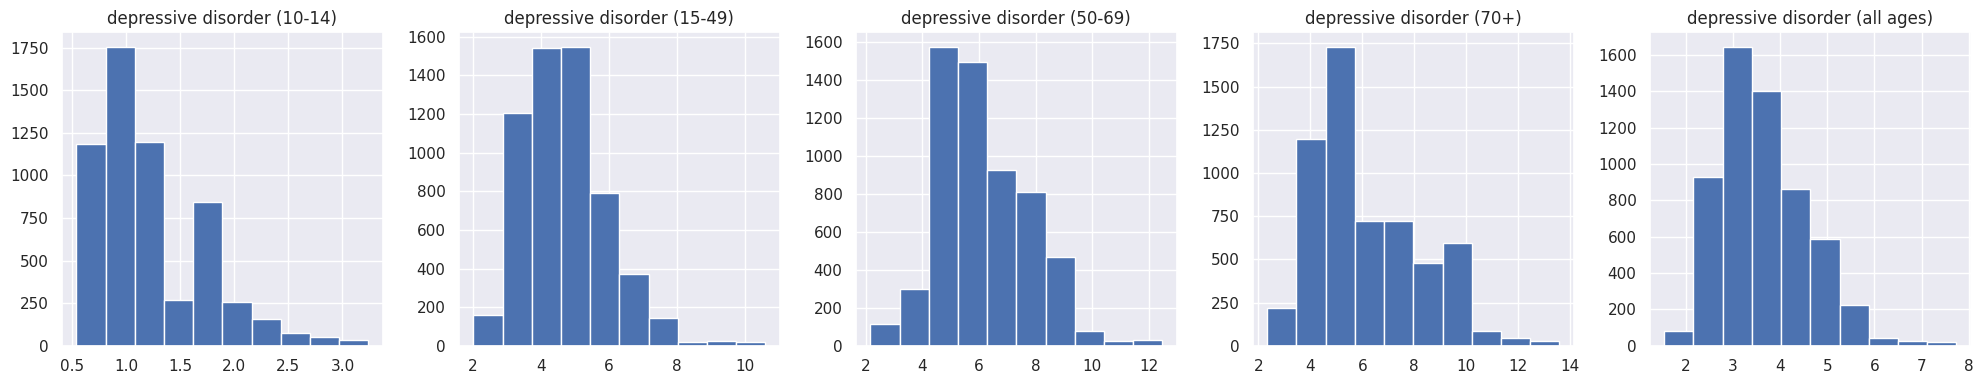

In [ ]:
fig, axes = plt.subplots(1,5)

for i, el in enumerate(list(df_psychopathology_age[columns_age].columns.values)):
  a = df_psychopathology_age[columns_age].hist(el, ax=axes.flatten()[i])
  
fig.set_size_inches(20, 4)
plt.tight_layout() 
plt.show()

In [140]:
df_kruskal=pd.melt(df_psychopathology_age[['country', 'depressive disorder (10-14)', 'depressive disorder (15-49)', 'depressive disorder (50-69)', 'depressive disorder (70+)', 'depressive disorder (all ages)']], id_vars='country')
df_kruskal.drop(['country'], axis=1, inplace=True)
df_kruskal.rename(columns={df_kruskal.columns[0]: 'grupa wiekowa', df_kruskal.columns[1]: 'częstotliwość'},inplace=True)

krus=kruskal(dv='częstotliwość', between='grupa wiekowa', data=df_kruskal)
krus

Source  ddof1             H  p-unc
Kruskal  grupa wiekowa      4  19686.590747    0.0

In [143]:
pip install scikit-posthocs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [148]:
import scikit_posthocs as sp

In [158]:
dunn=sp.posthoc_dunn(df_kruskal, val_col='częstotliwość', group_col='grupa wiekowa', p_adjust='bonferroni')
dunn

depressive disorder (10-14)  \
depressive disorder (10-14)                             1.0   
depressive disorder (15-49)                             0.0   
depressive disorder (50-69)                             0.0   
depressive disorder (70+)                               0.0   
depressive disorder (all ages)                          0.0   

                                depressive disorder (15-49)  \
depressive disorder (10-14)                    0.000000e+00   
depressive disorder (15-49)                    1.000000e+00   
depressive disorder (50-69)                   1.104558e-281   
depressive disorder (70+)                     3.800888e-198   
depressive disorder (all ages)                1.473384e-221   

                                depressive disorder (50-69)  \
depressive disorder (10-14)                    0.000000e+00   
depressive disorder (15-49)                   1.104558e-281   
depressive disorder (50-69)                    1.000000e+00   
depressive disorder (70+)                      5.876085e-08   
depressive disorder (all ages)                 0.000000e+00   

                                depressive disorder (70+)  \
depressive disorder (10-14)                  0.000000e+00   
depressive disorder (15-49)                 3.800888e-198   
depressive disorder (50-69)                  5.876085e-08   
depressive disorder (70+)                    1.000000e+00   
depressive disorder (all ages)               0.000000e+00   

                                depressive disorder (all ages)  
depressive disorder (10-14)                       0.000000e+00  
depressive disorder (15-49)                      1.473384e-221  
depressive disorder (50-69)                       0.000000e+00  
depressive disorder (70+)                         0.000000e+00  
depressive disorder (all ages)                    1.000000e+00

In [184]:
dunn>0.05

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The erro

depressive disorder (10-14)  \
depressive disorder (10-14)                            True   
depressive disorder (15-49)                           False   
depressive disorder (50-69)                           False   
depressive disorder (70+)                             False   
depressive disorder (all ages)                        False   

                                depressive disorder (15-49)  \
depressive disorder (10-14)                           False   
depressive disorder (15-49)                            True   
depressive disorder (50-69)                           False   
depressive disorder (70+)                             False   
depressive disorder (all ages)                        False   

                                depressive disorder (50-69)  \
depressive disorder (10-14)                           False   
depressive disorder (15-49)                           False   
depressive disorder (50-69)                            True   
depressive disorder (70+)                             False   
depressive disorder (all ages)                        False   

                                depressive disorder (70+)  \
depressive disorder (10-14)                         False   
depressive disorder (15-49)                         False   
depressive disorder (50-69)                         False   
depressive disorder (70+)                            True   
depressive disorder (all ages)                      False   

                                depressive disorder (all ages)  
depressive disorder (10-14)                              False  
depressive disorder (15-49)                              False  
depressive disorder (50-69)                              False  
depressive disorder (70+)                                False  
depressive disorder (all ages)                            True

Każda z badanych grup wiekowych - w stosunku do pozostałych grup - różni się w sposób istotny stastystycznie (na poziomie α=0.05) częstotliwością występowania depresji.